## Sentimental Analysis using Transformers

We will go through how to fine-tune BERT for sentiment analysis. we will perform the required text preprocessing (special tokens, padding, and attention masks) and build a Sentiment Classifier using the Transformers library

## What Exactly is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers.

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)

- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. 
In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words.

- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence.

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.


### Installing Libraries

In [11]:
! pip install transformers==2.8.0
! pip install torch==1.4.0

  Using cached torch-1.4.0-cp37-cp37m-manylinux1_x86_64.whl (753.4 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0
    Uninstalling torch-1.10.0:
      Successfully uninstalled torch-1.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
pytorch-lightning 1.5.5 requires torch>=1.7.*, but you have torch 1.4.0 which is incompatible.


## Importing Libraries

In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Downloading Dataset

we are using google play store dataset , containing app reviews

In [4]:
# downloading app dataset file
!gdown --id 1e4ZMMDbk3Pxigr2mwhxUnyrp8cRfkdb_

# downloading reviews file
!gdown --id 1tAzvMa1t4NilZAOpf4yjt7PHRw3mtl4u

Downloading...
From: https://drive.google.com/uc?id=1e4ZMMDbk3Pxigr2mwhxUnyrp8cRfkdb_
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 49.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tAzvMa1t4NilZAOpf4yjt7PHRw3mtl4u
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 112MB/s]


## Data Analysis and Preprocessing

In [5]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


We have about 16k examples with no missing values

## Check for Class Imbalance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'review score')

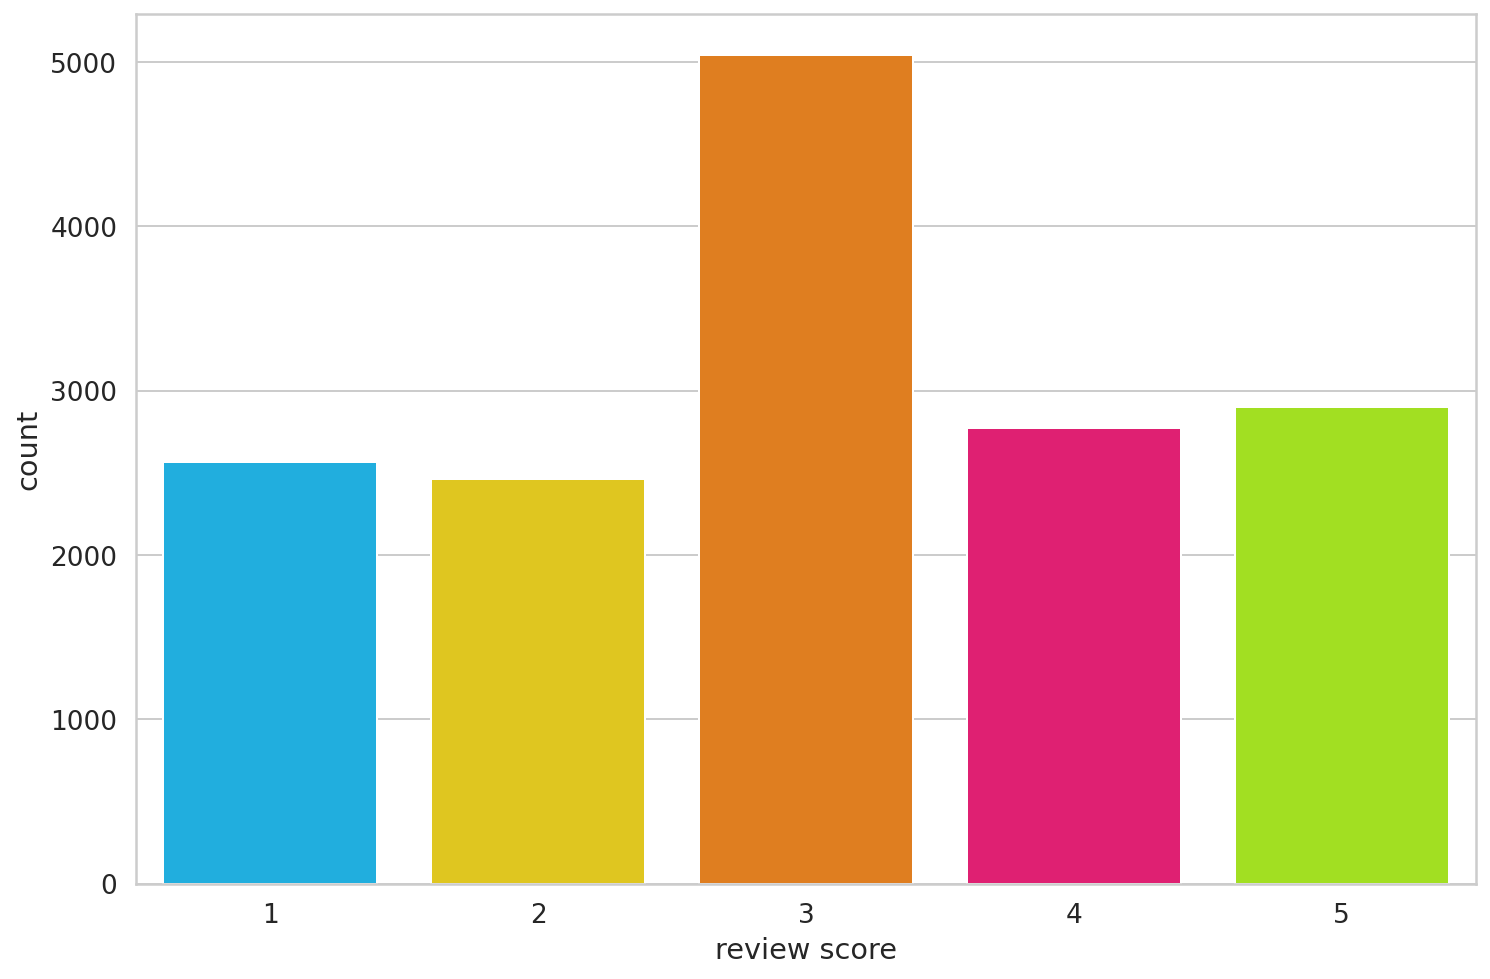

In [7]:
sns.countplot(df.score)
plt.xlabel('review score')

### Our Dataset is hugely imbalanced, We're going to convert the dataset into negative, neutral and positive sentiment:

In [8]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


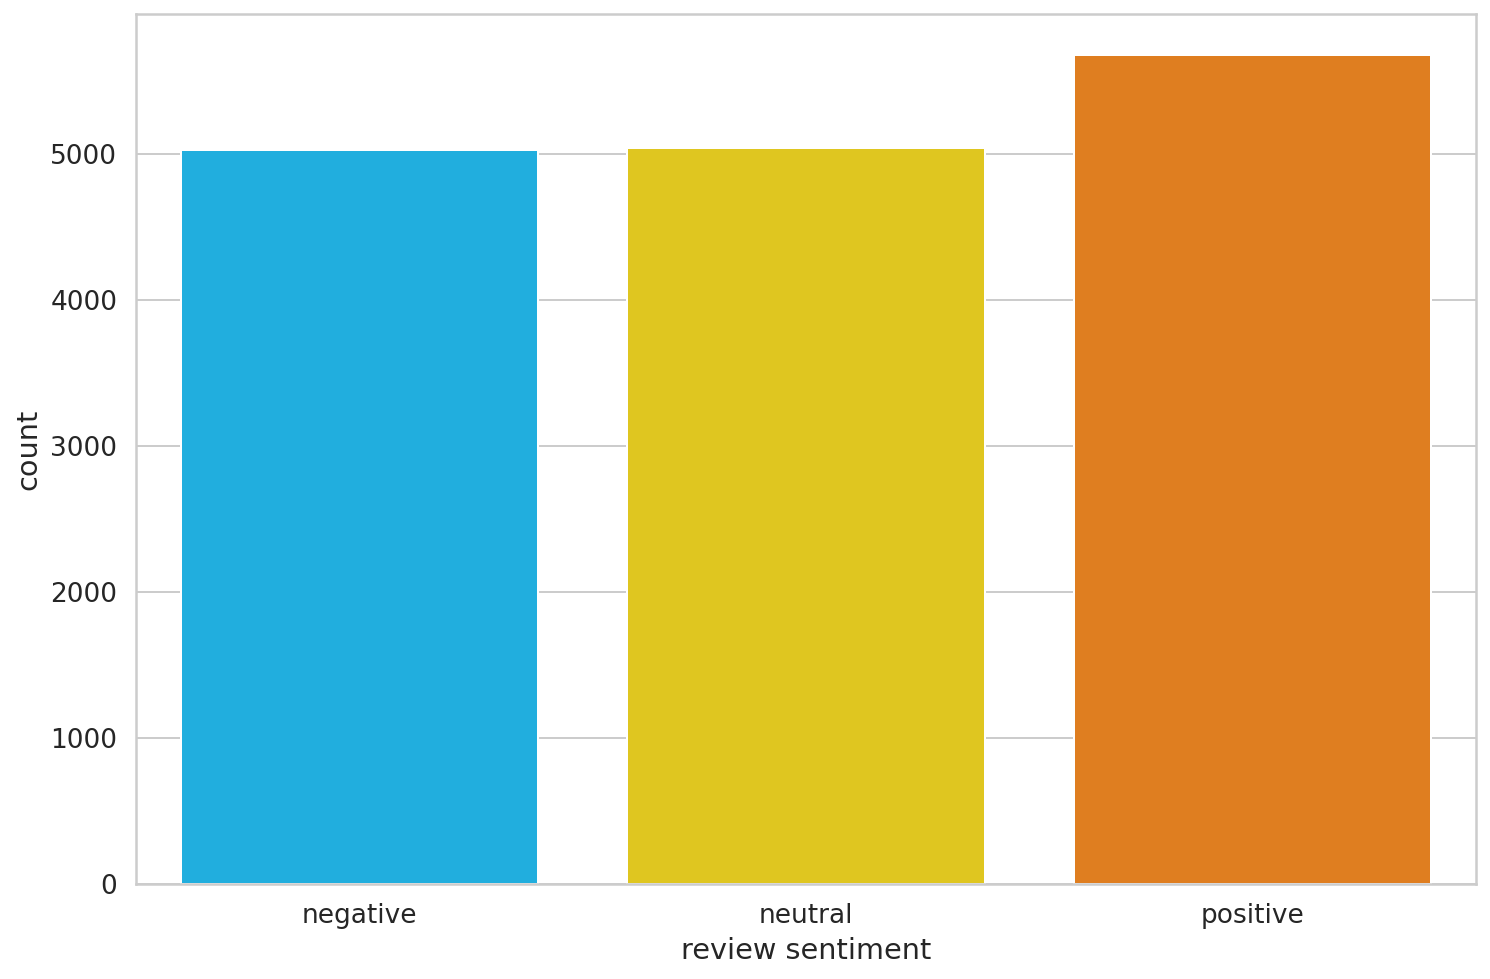

In [9]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

### Now the Balance has been restored

### Preprocessing

1. Add special tokens to separate sentences and do classification
2. Pass sequences of constant length (introduce padding)
3. Create array of 0s (pad token) and 1s (real token) called attention mask

The Transformers library provides a wide variety of Transformer models, It works with TensorFlow and PyTorch. It also includes prebuild tokenizers that do the heavy lifting for us.

In [10]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

## Loading Pretrained Bert Tokenizer

In [11]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

## Understanding Tokenization Process

In [12]:
sample_txt = "Delta plane makes emergency landing after passenger assaults flight attendant and air marshal"

Some basic operations can convert the text to tokens and tokens to unique integers (ids)

In [13]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Delta plane makes emergency landing after passenger assaults flight attendant and air marshal
   Tokens: ['Delta', 'plane', 'makes', 'emergency', 'landing', 'after', 'passenger', 'assaults', 'flight', 'attendant', 'and', 'air', 'marshal']
Token IDs: [7679, 4261, 2228, 5241, 4636, 1170, 4059, 25720, 3043, 19389, 1105, 1586, 23963]


### Special Tokens

[SEP] - marker for ending of a sentence

[CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification

[PAD]special token for padding

In [14]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)

[SEP] 102
[CLS] 101
[PAD] 0


### BERT understands tokens that were in the training set. Everything else can be encoded using the [UNK] (unknown) token

In [15]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

[UNK] 100


## Encoding

In [16]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

### The token ids are now stored in a Tensor and padded to a length of 32

In [17]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  7679,  4261,  2228,  5241,  4636,  1170,  4059, 25720,  3043,
        19389,  1105,  1586, 23963,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [18]:
# Attention Mask
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

### Inversing the tokenization to have a look at the special tokens

In [19]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Delta',
 'plane',
 'makes',
 'emergency',
 'landing',
 'after',
 'passenger',
 'assaults',
 'flight',
 'attendant',
 'and',
 'air',
 'marshal',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. 
We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [20]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

### plot the distribution:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


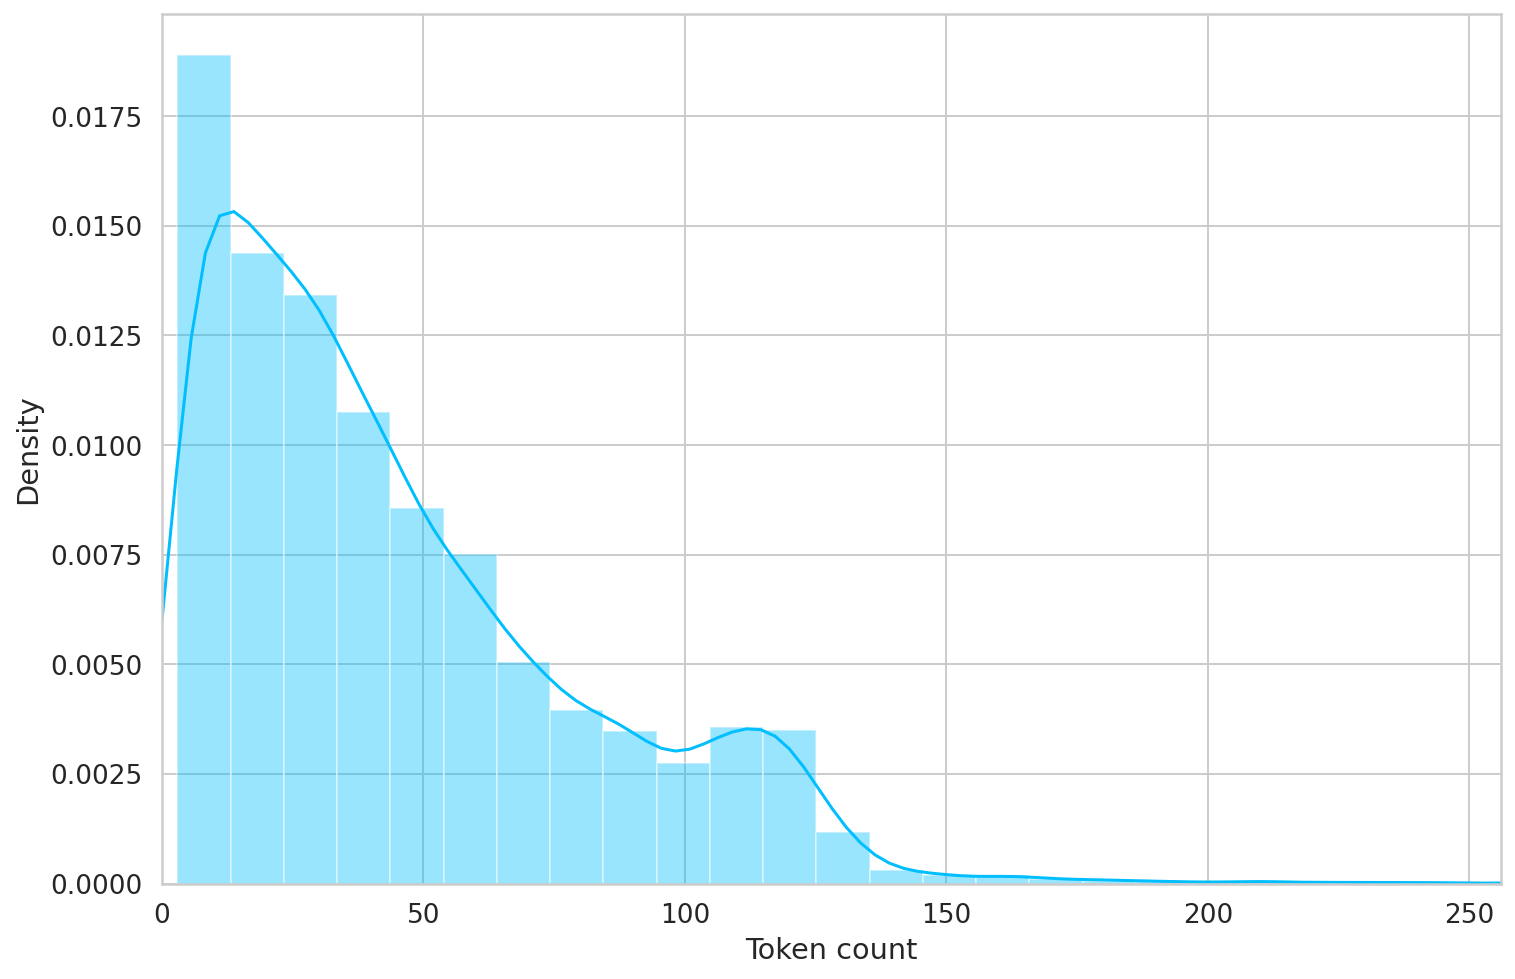

In [21]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll choose 160

In [22]:
MAX_LEN = 160

## Transformers Class

In [23]:
class GooglePlayStoreReviewDataset:
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model.

## Train and Testing

In [24]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 40

df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [25]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

## Data Loaders

In [26]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GooglePlayStoreReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [27]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

### Example batch from our training data loader:

In [28]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [29]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


### Sentiment Classification with BERT and Hugging Face

In [30]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [32]:
# encoding of our sample text

last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The last_hidden_state is a sequence of hidden states of the last layer of the model. Obtaining the pooled_output is done by applying the BertPooler on last_hidden_state

In [33]:
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence).768 -This is the number of hidden units in the feedforward-networks. 

In [34]:
print(bert_model.config.hidden_size)

768


### Classifier that uses the BERT Model

In [35]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.


In [36]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [37]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [38]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5636, 0.1088, 0.3276],
        [0.4477, 0.2027, 0.3497],
        [0.4345, 0.1908, 0.3747],
        [0.3467, 0.0797, 0.5737],
        [0.3908, 0.1162, 0.4930],
        [0.3629, 0.0929, 0.5442],
        [0.5153, 0.1612, 0.3236],
        [0.5654, 0.1638, 0.2708],
        [0.3164, 0.1875, 0.4961],
        [0.2914, 0.1394, 0.5692],
        [0.4109, 0.1867, 0.4024],
        [0.4778, 0.1946, 0.3276],
        [0.3514, 0.1796, 0.4690],
        [0.3629, 0.1192, 0.5179],
        [0.4178, 0.2519, 0.3304],
        [0.5136, 0.1671, 0.3193]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Training Model

To reproduce the training procedure from the BERT paper, we'll use the AdamW optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper.

In [39]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

hyperparameters- The BERT authors have some recommendations for fine-tuning:

1. Batch size: 16, 32
2. Learning rate (Adam): 5e-5, 3e-5, 2e-5
3. Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

In [40]:
def train_epoch( model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. 
The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using clip_grad_norm_.

Let's write another one that helps us evaluate the model on a given data loader

In [41]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

## Training Loop

In [42]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7617901381668604 accuracy 0.6505539482040787
Val   loss 0.5414048072695732 accuracy 0.7623888182973316

Epoch 2/10
----------
Train loss 0.4495889697366859 accuracy 0.8230188412956038
Val   loss 0.4407869300246239 accuracy 0.8310038119440916

Epoch 3/10
----------
Train loss 0.24677604317042817 accuracy 0.9172958859642933
Val   loss 0.5015999322757125 accuracy 0.8691232528589581

Epoch 4/10
----------
Train loss 0.171095425868512 accuracy 0.9517324112624375
Val   loss 0.5854805881297216 accuracy 0.8754764930114358

Epoch 5/10
----------
Train loss 0.12147426972392752 accuracy 0.9652812081010514
Val   loss 0.5201269873976707 accuracy 0.8919949174078781

Epoch 6/10
----------
Train loss 0.09064271681509496 accuracy 0.976007338931621
Val   loss 0.6075693222880364 accuracy 0.8970775095298603

Epoch 7/10
----------
Train loss 0.06644343280631042 accuracy 0.9812292710465035
Val   loss 0.5632778085768223 accuracy 0.9085133418043202

Epoch 8/10
----------
Tra

## Training vs Validation accuracy

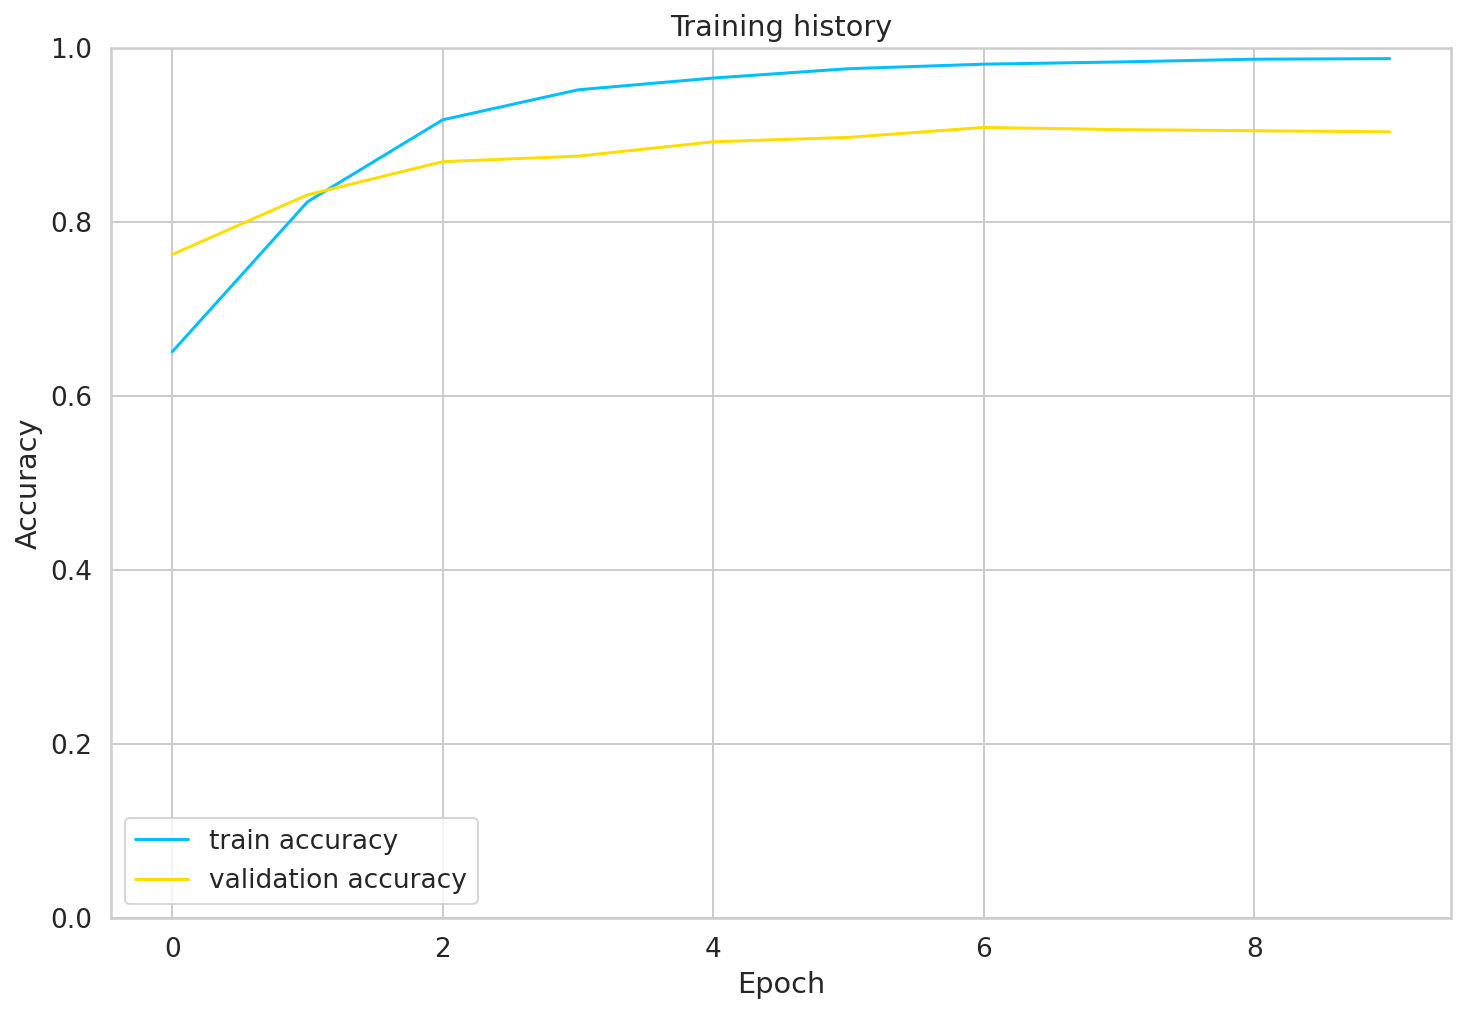

In [48]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation

In [43]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8616751269035532

## Prediction Function

In [49]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [50]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_data_loader)

## Classification Report

In [51]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.90      0.88      0.89       246
     neutral       0.76      0.85      0.80       229
    positive       0.92      0.85      0.89       313

    accuracy                           0.86       788
   macro avg       0.86      0.86      0.86       788
weighted avg       0.87      0.86      0.86       788



## Confusion Matrix

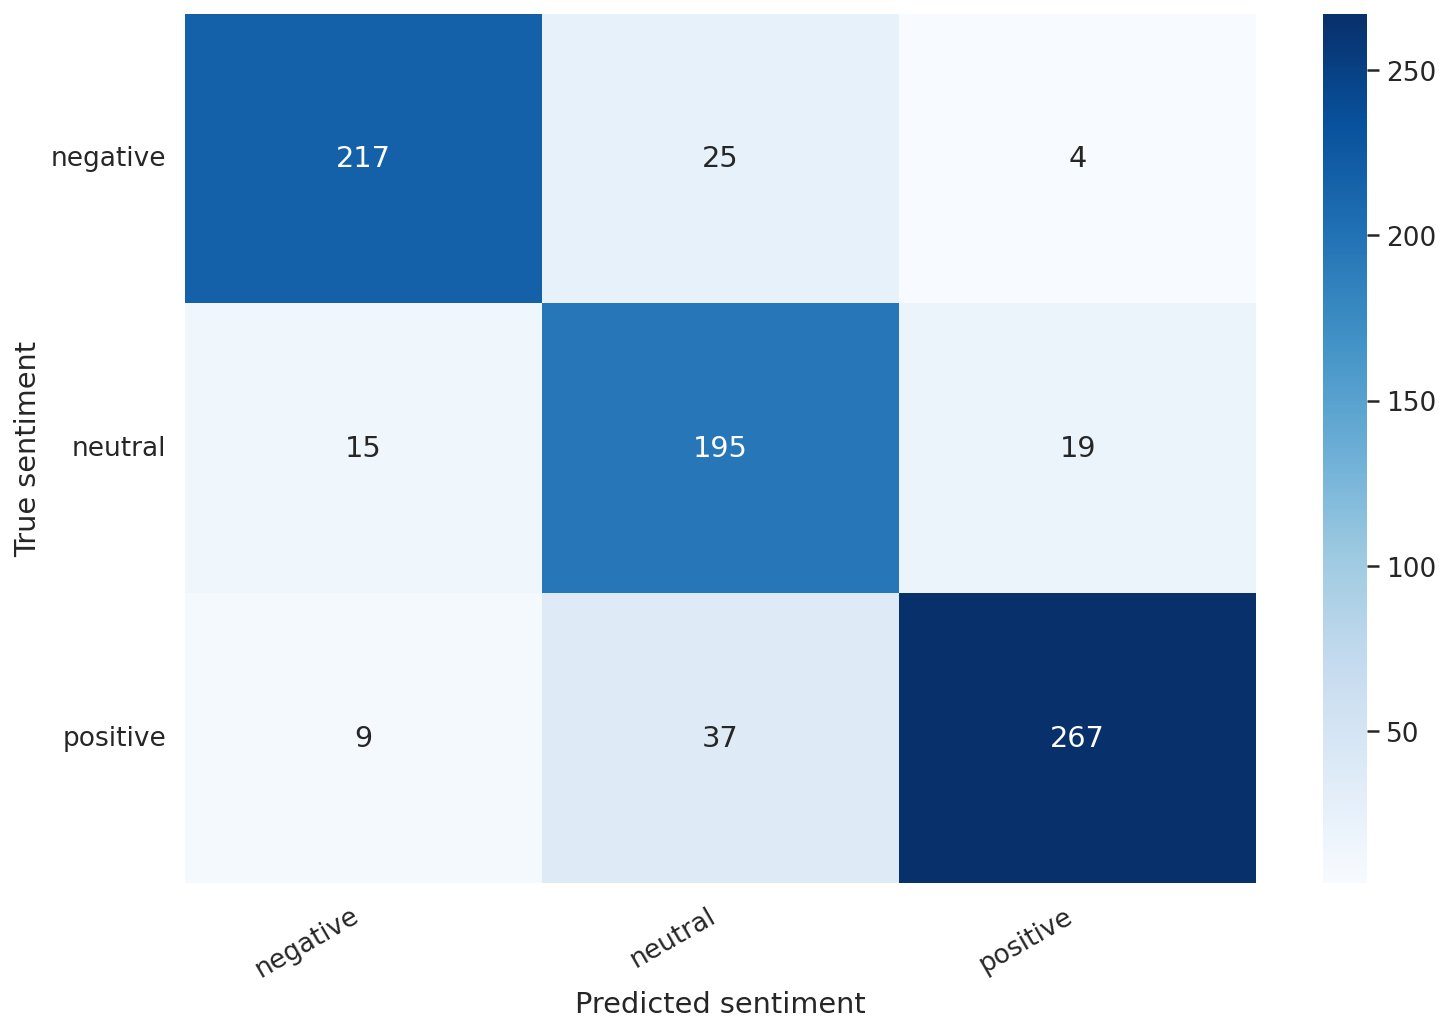

In [52]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model.

## Prediction on Raw Text

In [53]:
review_text = "Delta plane makes emergency landing after passenger assaults flight attendant and air marshal"

encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

# model predictions
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Delta plane makes emergency landing after passenger assaults flight attendant and air marshal
Sentiment  : negative
